In [2]:
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy.signal import savgol_filter

In [2]:
def parse_log(content):
    iter_re = r'iteration\s*(\d+)/\s*\d+'
    time_re = r'elapsed time per iteration \(ms\): (\d+\.\d+)'
    iters, times = re.findall(iter_re, content), re.findall(time_re, content)
    return np.array(sorted([int(i) for i in iters])), np.array([float(i) for i in times if float(i) < 10000])

def draw_itertime(itertimes):
    itertimes = np.array(itertimes)
    yhat = itertimes
    # yhat = savgol_filter(itertimes, 5, 3) 
    plt.plot(np.cumsum(yhat)/1000, yhat)
    plt.xlabel("Iteration number")
    plt.ylabel("Iteration time / ms")

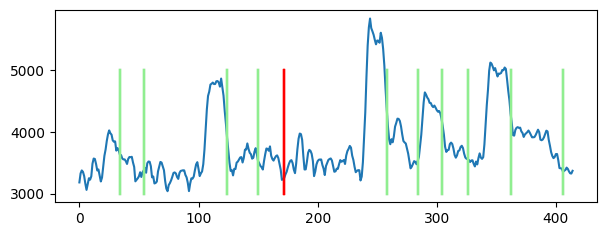

In [3]:
with open("../Megatron-failslow/trainlog/log_2024_09_03_17_01_27_334278_rank7/megatron_output_7.log", 'r') as f:
    content = f.read()

plt.figure(figsize=(7, 2.5))
ts = []
tps = []
splits = []
for line in content.split("\n"):
    if '[Training paused]' in line:
        tps.append(len(ts))
    if '####' in line:
        splits.append(len(ts))
    if 'elapsed time per iteration' not in line:
        continue
    time_re = r'elapsed time per iteration \(ms\): (\d+\.\d+)'
    itime = float(re.findall(time_re, line)[0])
    if itime < 10000:
        ts.append(itime)

plt.plot(np.arange(len(ts)), savgol_filter(ts, 10, 3))
for eid, i in enumerate(splits):
    # if eid % 3 != 5:
    plt.plot([i, i], [3000, 5000], color='lightgreen')
for i in tps:
    plt.plot([i, i], [3000, 5000], color='red')


[599.3721999999996, 602.7138999999995, 605.9657999999995, 605.9757999999995, 685.9757999999995] 175
[0.30938679537157354, 0.2992488852979023, 0.30751253113564375, 0, 0] 175
[2053.065799999999, 2057.045999999999, 2060.8374999999987, 2060.847499999999, 2140.847499999999] 534
[0.25150272880460756, 0.2512436560976835, 0.2637478570486615, 0, 0] 534
Mitigated thpt (iters/min): 16.15446449701834
Original thpt (iters/s): 14.789532867924265
Healthy:  16.678426977063918
Improvement: 9.229038139902002%
[0, 605.9657999999995, 605.9757999999995, 2060.8374999999987, 2060.847499999999, 2974.442700000002]


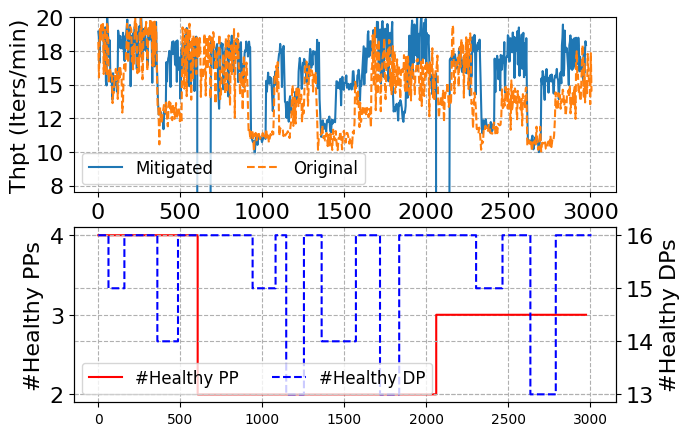

In [440]:
from matplotlib.ticker import FormatStrFormatter
with open("../Megatron-failslow/trainlog/alladjust.log", 'r') as f:
    content = f.read()
fsz = 16

plt.figure(figsize=(7, 5))
plt.subplot(211)
ts = [0]
tps = []
splits = [0,]
xs = [0]
oldsleep = 0.0
for line in content.split("\n"):
    if '[Training paused]' in line:
        splits.append(xs[-1])
        splits.append(xs[-1]+ 0.01)
        tps.append(len(ts))
        ts.append(0)
        last_x = xs[-1]
        xs.append(last_x+0.01)
        ts.append(0)
        xs.append(last_x+80.01)
        print(xs[-5:], len(xs))
        print(ts[-5:], len(ts))
    if '[ClientWrapper]' in line:
        sleeptime = float(line.split("to ")[-1])
        if sleeptime != oldsleep:
            oldsleep = sleeptime
    if 'elapsed time per iteration' not in line:
        continue
    time_re = r'elapsed time per iteration \(ms\): (\d+\.\d+)'
    itime = float(re.findall(time_re, line)[0]) / 1000
    if itime < 10:
        ts.append(1/itime)
        xs.append(xs[-1] + itime)
splits.append(xs[-1])
plt.plot(xs[1:], 60*np.array(ts[1:]), label='Mitigated')
mit = np.mean(ts)


with open("../Megatron-failslow/trainlog/log_2024_09_03_17_52_53_682414_rank7/megatron_output_7.log", 'r') as f:
    content = f.read()

xs = [0]
ts = [0]
oldsleep = 0.0
for line in content.split("\n"):
    if 'elapsed time per iteration' not in line:
        continue
    time_re = r'elapsed time per iteration \(ms\): (\d+\.\d+)'
    itime = float(re.findall(time_re, line)[0]) / 1000
    if itime < 10:
        ts.append(1/itime)
        xs.append(xs[-1] + itime)


plt.plot(xs[1:], 60*np.array(ts[1:]), '--', label='Original')
plt.legend(fontsize=fsz-4, ncols=2, loc='lower left')
plt.xticks(fontsize=fsz)
plt.yticks(fontsize=fsz)
plt.ylabel("Thpt (Iters/min)", fontdict={"size": fsz})
plt.grid(linestyle='--')

org = np.mean(ts)
plt.ylim(7, 20)
print("Mitigated thpt (iters/min):", 60*mit)
print("Original thpt (iters/s):", 60*org)
print("Healthy: ", 60*np.mean(ts[:30]))
print(f"Improvement: {(mit-org)/org*100}%")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.subplot(212)
print(splits)
lpp = plt.plot(splits, [4, 4, 2, 2, 3, 3], color='red', label='#Healthy PP')
plt.yticks([2, 3, 4], ['2', '3', '4'])
plt.yticks(fontsize=fsz)
plt.gca().set_ylabel("#Healthy PPs", fontdict={"size": fsz})
handles, labels = plt.gca().get_legend_handles_labels()
plt.grid(linestyle='--')
ax2 = plt.twinx()
xx = np.array([0,
     212, 212.01, 212+97, 212+97.01, 
     510, 510.01, 510+126, 510+126.01,
     1091, 1091.01, 1091+140, 1091+140.01,
     1296, 1296.01, 1296+108, 1296.01+108,
     1512, 1512.01, 1512+209, 1512.01+209,
     1868, 1868.01, 1868+117, 1868.01+117,
     2454, 2454.01, 2454+161, 2454.01+161,
     2785, 2785.01, 2785+155, 2785.01+155,
    xs[-1]]) - 150
xx[0] = 0; xx[-1]+=150
yy = [16,
     16, 15, 15, 16,
     16, 14, 14, 16,
     16, 15, 15, 16,
     16, 13, 13, 16,
     16, 14, 14, 16,
     16, 13, 13, 16,
     16, 15, 15, 16,
     16, 13, 13, 16,
     16]
ldp = ax2.plot(xx, yy, '--', color='blue', label='#Healthy DP')
h2, l2 = ax2.get_legend_handles_labels()
handles += h2
labels += l2
plt.xticks(fontsize=fsz)
plt.yticks(fontsize=fsz)
ax2.set_ylabel("#Healthy DPs", fontdict={"size": fsz})
plt.legend(handles, labels, fontsize=fsz-4, ncols=2, loc='lower left')
plt.xlabel("Time", fontdict={"size": fsz})
plt.grid(linestyle='--')

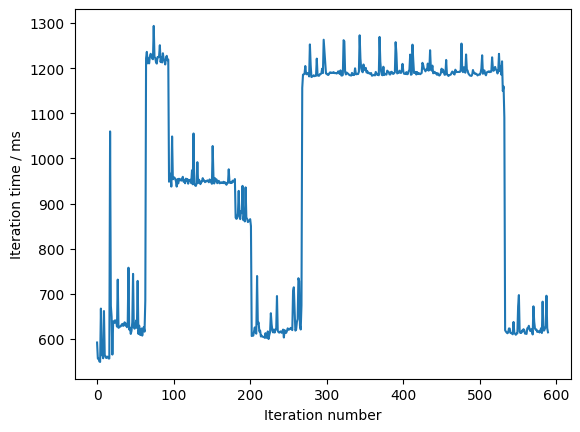

In [111]:
with open("../Megatron-failslow/trainlog/log_2024_08_31_22_42_12_129786_rank7/megatron_output_7.log", 'r') as f:
    content = f.read()

iters, times = parse_log(content)
draw_itertime(times[1:])

In [169]:
def parse_new_comm_log(log_path):
    with open(log_path, 'r') as f:
        content = f.read()
    contents = content.split("[Training paused]")
    times = []
    for i in range(len(contents)):
        _, ts = parse_log(contents[i])
        times.append(np.mean(ts))
    # first part of log: normal, second: fail-slow, third: mitigated, forth: normal
    assert len(times) == 4
    return (times[0] + times[-1]) / 2, times[1], times[2]


[838.2447368421053, 952.1843749999999, 989.0499999999998]
[802.3769230769232, 856.220754716981, 869.1153846153846]
[603.9659544159545, 605.1889376218323, 607.3102678571429]


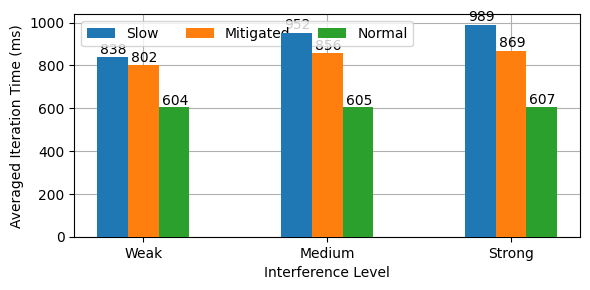

In [286]:
normal, slow, mitigate = [], [], []

logs = ["../Megatron-failslow/trainlog/log_2024_09_02_13_37_12_217839_rank7/megatron_output_7.log", # tensor size = 200MB, sync at the end (strong interference)
        "../Megatron-failslow/trainlog/log_2024_09_02_13_24_43_621788_rank7/megatron_output_7.log", # tensor size = 50MB, sync CUDA after each repeat (weak interference)
        "../Megatron-failslow/trainlog/log_2024_09_02_13_31_01_017561_rank7/megatron_output_7.log", # tensor size = 100MB, sync CUDA after each repeat (medium interference)
        ]

xlabels = ["Weak", "Medium", "Strong"]

for log in logs:
    n, s, m = parse_new_comm_log(log)
    normal.append(n)
    slow.append(s)
    mitigate.append(m)

plt.figure(figsize=(6, 3))
legends = ['Slow', 'Mitigated', 'Normal']
for i, data in enumerate([slow, mitigate, normal]):
    plt.bar(len(logs) * np.arange(len(data)) + 0.5*i, data, width=0.5, label=legends[i], zorder=100)
    print(data)
    for j in range(len(data)):
        plt.text(len(logs) * j + 0.5*i - 0.2, data[j] * 1.02, "{:.0f}".format(data[j]))

plt.grid(zorder=0)
plt.legend(ncols=3, loc='upper left')
plt.xticks([0.5, 3.5, 6.5], xlabels)
plt.xlabel("Interference Level")
plt.ylabel("Averaged Iteration Time (ms)")
plt.tight_layout()

[650.1457142857143, 705.3599999999999, 939.1694444444444]
[602.1701388888889, 636.6714285714286, 773.2048543689323]
[578.5563726604532, 576.5486638221423, 572.0064084353146]


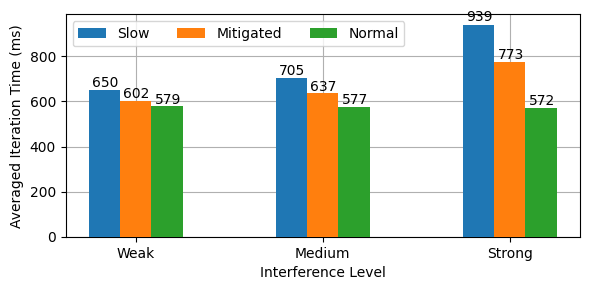

In [153]:
normal, slow, mitigate = [], [], []

logs = ["./usefullog/log_2024_08_30_20_37_41_480525_rank7/megatron_output_7.log", # tensor size = 50MB, sync CUDA after each repeat (weak interference)
        "./usefullog/log_2024_08_30_20_09_15_279528_rank7/megatron_output_7.log", # tensor size = 100MB, sync CUDA after each repeat (medium interference)
        "./usefullog/log_2024_08_30_20_26_20_119115_rank7/megatron_output_7.log", # tensor size = 200MB, sync at the end (strong interference)
        ]

xlabels = ["Weak", "Medium", "Strong"]

for log in logs:
    n, s, m = parse_new_comm_log(log)
    normal.append(n)
    slow.append(s)
    mitigate.append(m)

plt.figure(figsize=(6, 3))
legends = ['Slow', 'Mitigated', 'Normal']
for i, data in enumerate([slow, mitigate, normal]):
    plt.bar(len(logs) * np.arange(len(data)) + 0.5*i, data, width=0.5, label=legends[i], zorder=100)
    print(data)
    for j in range(len(data)):
        plt.text(len(logs) * j + 0.5*i - 0.2, data[j] * 1.02, "{:.0f}".format(data[j]))

plt.grid(zorder=0)
plt.legend(ncols=3, loc='upper left')
plt.xticks([0.5, 3.5, 6.5], xlabels)
plt.xlabel("Interference Level")
plt.ylabel("Averaged Iteration Time (ms)")
plt.tight_layout()

In [172]:
def parse_ppstage_comm_log(log_path):
    with open(log_path, 'r') as f:
        content = f.read()
    contents = content.split("[Training paused]")
    times = []
    for i in range(len(contents)):
        _, ts = parse_log(contents[i])
        times.append(np.mean(ts))
    # first part of log: normal, second: fail-slow
    return times

n1, s1, m1 = parse_new_comm_log("./usefullog/log_2024_08_30_21_24_01_093148_rank7/megatron_output_7.log") # 1PP with mitigate
n2, s2 = parse_ppstage_comm_log("./usefullog/log_2024_08_30_21_05_56_801291_rank7/megatron_output_7.log") # 2PP
n3, s3 = parse_ppstage_comm_log("./usefullog/log_2024_08_30_21_12_38_149038_rank7/megatron_output_7.log") # 3PP
n4, s4, m4 = parse_new_comm_log("./usefullog/log_2024_08_30_21_37_14_051662_rank7/megatron_output_7.log")

print(n1, m1, s1)
print(n2, s2)
print(n3, s3)
print(n4, s4, m4)

573.4733187363154 767.8745454545453 910.5916666666666
576.1176056338029 975.6306878306879
574.3539007092198 1085.1727272727273
577.7600680272109 1145.1257142857144 1143.2738095238096


[910.5916666666666, 975.6306878306879, 1085.1727272727273, 1145.1257142857144]
[767.8745454545453, 773.204854368932, 975.1435438918351, 1143.2738095238096]
[573.4733187363154, 576.1176056338029, 574.3539007092198, 577.7600680272109]


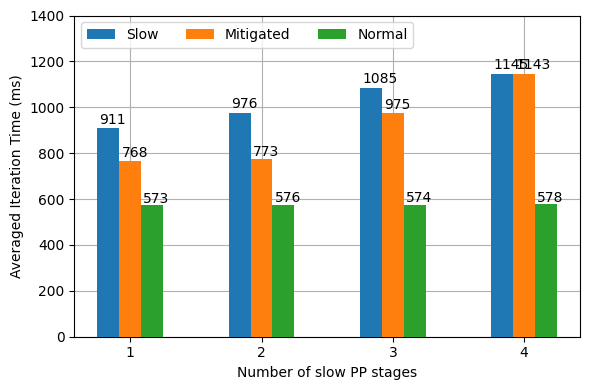

In [175]:
normal = [573.4733187363154, 576.1176056338029, 574.3539007092198, 577.7600680272109]
slow = [910.5916666666666, 975.6306878306879, 1085.1727272727273, 1145.1257142857144]
mitigate = [767.8745454545453, 773.204854368932, 975.1435438918351, 1143.2738095238096]

plt.figure(figsize=(6, 4))
legends = ['Slow', 'Mitigated', 'Normal']
xlabels = ["1", "2", "3", "4"]
for i, data in enumerate([slow, mitigate, normal]):
    plt.bar(len(logs) * np.arange(len(data)) + 0.5*i, data, width=0.5, label=legends[i], zorder=100)
    print(data)
    for j in range(len(data)):
        plt.text(len(logs) * j + 0.5*i - 0.2, data[j] * 1.02, "{:.0f}".format(data[j]))

plt.grid(zorder=0)
plt.legend(ncols=3, loc='upper left')
plt.ylim(0, 1400)
plt.xticks([0.5, 3.5, 6.5, 9.5], xlabels)
plt.xlabel("Number of slow PP stages")
plt.ylabel("Averaged Iteration Time (ms)")
plt.tight_layout()

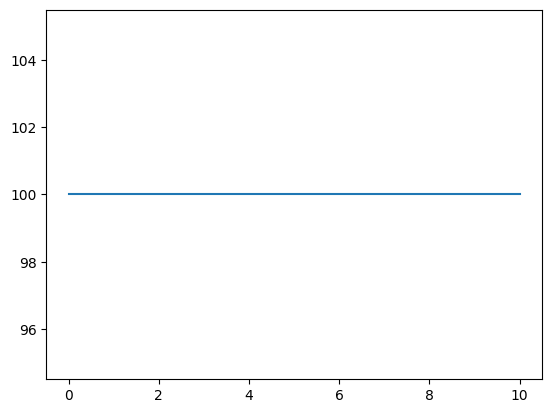

In [59]:
import numpy as np
import numpy.linalg as la

#### yuanji: modify it to your inputs ####
N = 100
tolerance = 1e-5
x = np.random.random((N, 3))
y = np.random.random((N, 3))
#### Ends here ####

numerical_ranks = np.zeros(11)
for n in range(11):
    move_matrix = np.zeros((N, 3))
    move_matrix[:, 0] += n
    moved_y = y + move_matrix
    distance_squared = np.sum((x[:, np.newaxis, :] - y[np.newaxis, :, :]) ** 2, axis=-1)
    A = 1 / np.sqrt(distance_squared)
    U, S, Vh = la.svd(A)
    rank = np.sum(S > tolerance)
    numerical_ranks[n] = rank

# Fill in these arrays
import matplotlib.pyplot as plt
plt.plot(numerical_ranks)